In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import matplotlib.cm as cm
import cPickle as pickle
import helpers
import fwd_sample as fs
import pymc3 as pm
reload(helpers)

<module 'helpers' from 'helpers.pyc'>

In [2]:
trace = pickle.load(open("all_data_trace.p", "rb"))
subj_data = pickle.load(open("all_data_subj.p", "rb"))

In [3]:
## Create dose colourmapper
## PYY
PYY_dict = {1.5:5, 7.5:8, 300.0:10}
PYY_norm = mpl.colors.Normalize(vmin = 0.0,
                                vmax = 10)

PYY_cmap = cm.Greens

PYY_dose_col = cm.ScalarMappable(norm=PYY_norm, cmap=PYY_cmap)

## Create day/night line and marker style
period_ms = {'L':'o', 'D':'^'}
period_ls = {'L':'-', 'D':'--'}

In [4]:
## Create metadata holder
metadata = []
groups = []

for i in subj_data:
    x = []
    group = i[0].split('/')[1]
    x.append(group)
    x += i[1].split('_')
    
    metadata.append(x)
    
    if group not in groups:
        groups.append(group)
        
group_id_dict = {}
for i, group_name in enumerate(groups):
    group_id_dict[i] = group_name
    
group_list = np.arange(len(groups))

In [5]:
## Index mask
rat_idx = np.unique(trace['theta1'][0,:], return_index=True)[1]
rat_idx = sorted(rat_idx)

## Subject data
subj_labels = []

for i in subj_data:
    subj_labels.append(i[1].split('_'))
    
subj_labels = np.array(subj_labels)

## Amount colourmapper
amts_save = []
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]    
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = helpers.amt_from_file(path, filename)
    amts_save.append(amt)
    
amt_norm = mpl.colors.Normalize(vmin = min(amts_save),
                                vmax = max(amts_save))

cmap = cm.plasma

amt_col = cm.ScalarMappable(norm=amt_norm, cmap=cmap)

# The model accurately recapitulates feeding summary statistics at the individual level

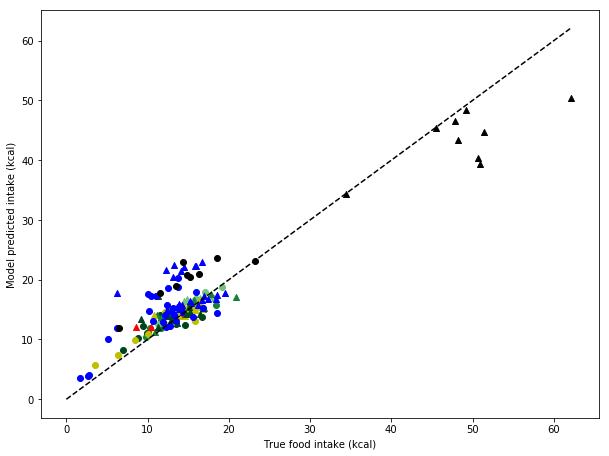

In [79]:
reload(helpers)
reload(fs)

num_samples = 1000
x0 = 0

full_post = helpers.get_dataset(trace, rat_idx)
"""
mean_amts = []
mean_rates = []

true_amts = []
true_rates = []

cs = []
"""

fig, ax = plt.subplots(1, figsize=(10,7.5))

for i, idx in enumerate(rat_idx):
    ## draw in true amounts
    data = subj_labels[i]    
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = helpers.amt_from_file(path, filename)
    #true_amts.append(amt)
    x = amt
    
    ## use to get duration for sampling
    tmax = 3600*helpers.infer_duration(filename)
    true_rates.append(amt/tmax)
    
    ## draw samples from posterior
    ## NOTE: currently uses posterior mean, not full posterior
    rat_post = full_post[:,:,i]
    theta = np.mean(rat_post, axis=1) # PM comes in here
    sample_amts = []
    sample_rates = []
    
    for j in range(num_samples):
        k = np.random.randint(3000)
        theta = rat_post[:,k]
        spl = fs.sample(tmax, theta, x0)[1]
        sample_amts.append(spl)
        sample_rates.append(spl/tmax)
        
    #mean_amts.append(np.mean(sample_amts))
    #mean_rates.append(np.mean(sample_rates))
    y = np.mean(sample_amts)

    ## Colour points by drug dose, marker style from photoperiod
    ms = period_ms[data[3]]
    label = data[0]+data[1]+data[3]
    c = helpers.get_colour(data[:4])
    #cs.append(c)
    
    ax.scatter(x, y, c=c, marker=ms)
    

## Now do the plotting


true = np.arange(np.max(true_amts))
#ax.scatter(true_amts, mean_amts, c=cs, marker=ms)
ax.plot(true, true, c='k', ls='--')

ax.set_ylabel('Model predicted intake (kcal)')
ax.set_xlabel('True food intake (kcal)')

"""
true = np.linspace(np.min(true_rates), np.max(true_rates), 1000)
ax.scatter(true_rates, mean_rates)
ax.plot(true, true, c='k', ls='--')

ax.set_xlim([min(true_rates), max(true_rates)])
ax.set_ylim([min(mean_rates), max(mean_rates)])
"""
plt.show()

In [22]:
print trace['theta1'].shape

(3000, 4966)
